MMD Value between two sets of Wigner distributions: 0.6044


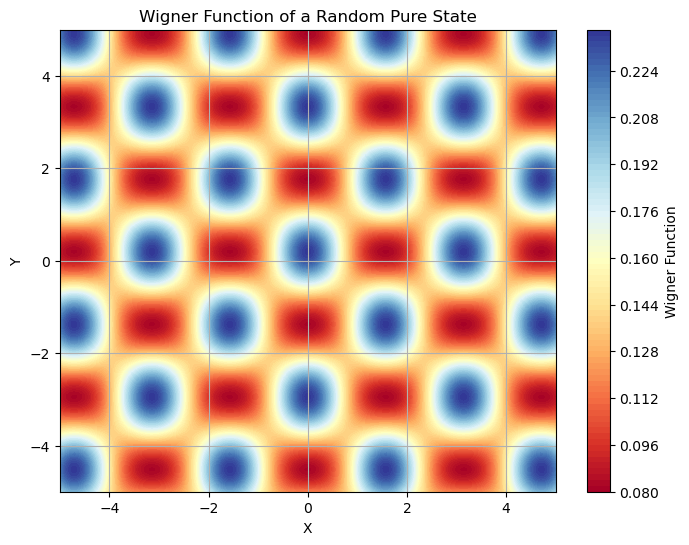

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def wigner_function(state, x, y):
    """
    Calculate the Wigner function for a given quantum state.
    
    Parameters:
    state: np.ndarray - Density matrix of the quantum state.
    x: np.ndarray - X-axis points.
    y: np.ndarray - Y-axis points.
    
    Returns:
    np.ndarray - Wigner function values.
    """
    W = np.zeros((len(x), len(y)), dtype=np.complex_)

    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            # Calculate the Wigner function using the density matrix
            for m in range(state.shape[0]):
                for n in range(state.shape[0]):
                    W[i, j] += state[m, n] * np.exp(-2j * (xi * (m - n) + yj * (m + n)))
                    
    return W / (2 * np.pi)

def random_pure_state(d):
    """
    Generate a random pure state in d-dimensional Hilbert space.
    
    Parameters:
    d: int - Dimension of the Hilbert space.
    
    Returns:
    np.ndarray - Random pure state (density matrix).
    """
    # Generate a random vector on the complex sphere (for pure state)
    theta = np.random.rand() * np.pi
    phi = np.random.rand() * 2 * np.pi
    
    state = np.zeros((d,), dtype=np.complex_)
    state[0] = np.cos(theta)
    state[1:] = np.sin(theta) * np.exp(1j * phi * np.arange(1, d))
    
    # Normalize
    return np.outer(state, np.conjugate(state))

def generate_wigner_distributions(num_states, d, num_points):
    """
    Generate Wigner distributions for a number of random quantum states.
    
    Parameters:
    num_states: int - Number of states to generate.
    d: int - Dimension of the Hilbert space.
    num_points: int - Number of points in each direction.
    
    Returns:
    List[np.ndarray] - List of Wigner functions.
    """
    x = np.linspace(-5, 5, num_points)
    y = np.linspace(-5, 5, num_points)
    
    wigner_distributions = []
    
    for _ in range(num_states):
        state = random_pure_state(d)
        W = wigner_function(state, x, y)
        wigner_distributions.append(np.real(W))  # Only real part for visualization and loss computation
    
    return wigner_distributions

# Example usage
num_states = 5  # Number of random states
d = 2  # Dimension of Hilbert space (e.g., qubit)
num_points = 200  # Number of points in each direction

# Generate Wigner distributions
X = generate_wigner_distributions(num_states, d, num_points)
Y = generate_wigner_distributions(num_states, d, num_points)

from qcbm.mmd import mmd_loss

# Calculate MMD loss

XX = [x.flatten() for x in X]
YY = [y.flatten() for y in Y]

mmd_value = mmd_loss(1.0, XX, YY)
print(f"MMD Value between two sets of Wigner distributions: {mmd_value:.4f}")

# Optional: Visualizing one of the Wigner functions
plt.figure(figsize=(8, 6))
plt.contourf(np.linspace(-5, 5, num_points), np.linspace(-5, 5, num_points), X[0], levels=100, cmap='RdYlBu')
plt.colorbar(label='Wigner Function')
plt.title('Wigner Function of a Random Pure State')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()
